<a href="https://colab.research.google.com/github/Rohitkumar-88/ML_Projects/blob/Colab_Notebooks/DecisionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


 **Train and fine tune desision trees for the moons dataset. Generate a moons dataset using make_moons(n_samples=10000, noise=0.4)**

**Adding random_state=42 to make this notebook's output constant.**

In [4]:
from sklearn.datasets import make_moons
x, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

**split in to a training set and test set using train_test_split().**

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

**Use grid search wirh cross validation (with the help of GridSearchCV class) to find good hyperparameter values for a Decision Tree Classifier**

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2,100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(x_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [7]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

**Train it on the full training set using these hyperparameters, and measure your model performance on the test set**

By default, the GridSearchCV trains the best model found on the whole training set (you can change it bt setting refit=False), so we don't need to do it again, we can simply evaluate the model accuracy.

In [8]:
from sklearn.metrics import accuracy_score
y_pred = grid_search_cv.predict(x_test)
accuracy_score(y_test, y_pred)

0.8695

**Random Forest**

**Grow a forest. Contuining the previous exercise grow a 1000 subsets of a training set, each containing 100 instances selected randomly**

In [9]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(x_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(x_train):
    x_mini_train = x_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((x_mini_train, y_mini_train))

**Train Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1000 decision trees on the test set**

In [10]:
from sklearn.base import clone
forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (x_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(x_mini_train, y_mini_train)
    y_pred = tree.predict(x_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.805471

**For each test set instance, generate the predictions of 1000 Decision Trees,and keep only the mnost frequent prediction. This gives you majority-vote predictions over the test set**

In [11]:
y_pred = np.empty([n_trees, len(x_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
  y_pred[tree_index] = tree.predict(x_test)

In [13]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(y_pred, axis=0, keepdims=False)

In [14]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872

# Voting Classifiers

Let's reference the law of large numbers (LLN) to setup voting classifiers.

In [15]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

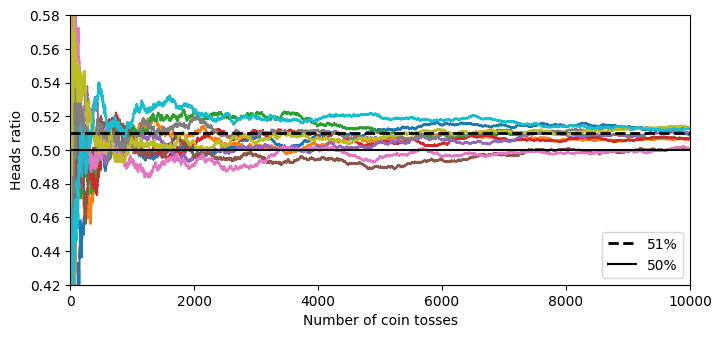

In [18]:
plt.figure (figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc = "lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.savefig("law_of_large_number_plot")
plt.show()



Spiliting the data set in to training and testing components

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x , y, random_state=42)

Training various classifiers

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf', rnd_clf),('svc', svm_clf)],
    voting="hard"
)

In [22]:
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

observing accuracy scores

In [27]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**Soft voting**

In [28]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf', rnd_clf),('svc', svm_clf)],
    voting="soft"
    )
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

Observing accuracy scores

In [29]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92
